In [12]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [14]:
def load_data(filename, FOLDER="./data"):
    csv_path = os.path.join(FOLDER, filename)
    return pd.read_csv(csv_path)

data_train = load_data("airline_preprocessed_data_train.csv")
data_train = data_train[:20000]
data_test = load_data("airline_preprocessed_data_test.csv")
data_test = data_test[:5000]

manually_selected_data_train = load_data("airline_manually_selected_data_train.csv")
manually_selected_data_train = manually_selected_data_train[:20000]
manually_selected_data_test  = load_data("airline_manually_selected_data_test.csv")
manually_selected_data_test  = manually_selected_data_train[:5000]

data_numerical_columns = data_train.select_dtypes(include=np.number).columns.tolist()
manual_data_numerical_columns = manually_selected_data_train.select_dtypes(include=np.number).columns.tolist()

data_numerical_columns.remove('satisfaction')
manual_data_numerical_columns.remove('satisfaction')

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion

data_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(data_numerical_columns)),
        ("imputer", SimpleImputer(strategy="median")),
    ])

manual_preprocess_pipeline = Pipeline([
         ("select_numeric", DataFrameSelector(manual_data_numerical_columns)),
         ("imputer", SimpleImputer(strategy="median")),
    ])

In [17]:
X_data_train = data_train.drop(['satisfaction'], axis=1)
X_manual_train = manually_selected_data_train.drop(['satisfaction'], axis=1)

X_data_test = data_test.drop(['satisfaction'], axis=1)
X_manual_test = manually_selected_data_test.drop(['satisfaction'], axis=1)

y_data_train = data_train['satisfaction'].values
y_manual_train = manually_selected_data_train['satisfaction'].values

y_data_test = data_test['satisfaction'].values
y_manual_test = manually_selected_data_test['satisfaction'].values

In [18]:
data_pipeline.fit_transform(X_data_train)

manual_preprocess_pipeline.fit_transform(X_manual_train)

array([[-0.18563234,  1.        ,  0.        , ...,  0.31185319,
         0.20352096,  1.        ],
       [-0.18563234,  2.        ,  1.        , ..., -0.53485418,
         0.20352096,  0.        ],
       [ 1.29647912,  2.        ,  1.        , ...,  0.31185319,
        -0.54957057,  1.        ],
       ...,
       [ 1.29647912,  0.        ,  1.        , ..., -2.22826893,
         1.70970403,  1.        ],
       [-0.18563234,  1.        ,  0.        , ...,  0.31185319,
         0.9566125 ,  1.        ],
       [ 1.29647912,  0.        ,  1.        , ..., -0.53485418,
         1.70970403,  1.        ]])

In [19]:
X_data_train = torch.from_numpy(data_pipeline.transform(X_data_train))
X_data_test = torch.from_numpy(data_pipeline.transform(X_data_test))

X_manual_train = torch.from_numpy(manual_preprocess_pipeline.transform(X_manual_train))
X_manual_test = torch.from_numpy(manual_preprocess_pipeline.transform(X_manual_test))

In [20]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_list, labels):
        'Initialization'
        self.labels = labels
        self.data_list = data_list

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_list)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.data_list[index]
        y = self.labels[index]

        return X, y

batch_size=512

data_training_set = Dataset(X_data_train, y_data_train)
data_training_generator = torch.utils.data.DataLoader(data_training_set, batch_size=batch_size, shuffle=True)

data_validation_set = Dataset(X_data_test, y_data_test)
data_validation_generator = torch.utils.data.DataLoader(data_validation_set, batch_size=batch_size, shuffle=False)

manual_training_set = Dataset(X_manual_train, y_manual_train)
manual_training_generator = torch.utils.data.DataLoader(manual_training_set, batch_size=batch_size, shuffle=True)

manual_validation_set = Dataset(X_manual_test, y_manual_test)
manual_validation_generator = torch.utils.data.DataLoader(manual_validation_set, batch_size=batch_size, shuffle=False)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
from collections import OrderedDict

class NeuralNet1(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet1, self).__init__()
        self.features = self._make_layers(input_size)
    
    def forward(self, x):
        out = self.features(x)
        return out
    
    @staticmethod
    def _make_layers(input_size):
        return nn.Sequential(OrderedDict([
          ('ln1', nn.Linear(input_size, 20)),
          ('relu1', nn.ReLU(inplace=True)),
          ('ln2', nn.Linear(20, 5)),
          ('relu2', nn.ReLU(inplace=True)),
          ('ln3', nn.Linear(5,2))
        ]))

model_data     = NeuralNet1(22).to(device)
model_manual   = NeuralNet1(11).to(device)
model_atomatic = NeuralNet1(11).to(device)

In [25]:
class NeuralNetBN(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetBN, self).__init__()
        self.features = self._make_layers(input_size)
    
    def forward(self, x):
        out = self.features(x)
        return out
    
    @staticmethod
    def _make_layers(input_size):
        return nn.Sequential(OrderedDict([
          ('ln1', nn.Linear(input_size, 20)),
          ('bn1', nn.BatchNorm1d(20)),
          ('relu1', nn.ReLU(inplace=True)),
          ('ln2', nn.Linear(20, 5)),
          ('bn2', nn.BatchNorm1d(5)),
          ('relu2', nn.ReLU(inplace=True)),
          ('ln3', nn.Linear(5,2)),
        ]))

model_data_bn     = NeuralNetBN(22).to(device)
model_manual_bn   = NeuralNetBN(11).to(device)
model_atomatic_bn = NeuralNetBN(11).to(device)

Prunning a module

In [26]:
module_data = model_data.features[2]
module_manual = model_manual.features[2]
module_data_bn = model_data_bn.features[3]
module_manual_bn = model_manual_bn.features[3]

In [27]:
print(list(module_data.named_parameters()))

[('weight', Parameter containing:
tensor([[-0.2093, -0.1821,  0.1799, -0.0912, -0.1365,  0.2128, -0.1226, -0.1118,
          0.1526,  0.1986, -0.1638,  0.1813, -0.2193,  0.2181,  0.0374, -0.0207,
          0.0836,  0.1943, -0.0891,  0.1611],
        [ 0.2138, -0.1452,  0.0856,  0.2097, -0.0959, -0.0416, -0.1430, -0.1192,
         -0.0660,  0.0140,  0.1928,  0.1679,  0.2156,  0.2234,  0.1746, -0.2014,
          0.0034,  0.0149, -0.0270, -0.2072],
        [ 0.0063, -0.2130,  0.1861,  0.0113,  0.1676,  0.0630, -0.2114,  0.1199,
          0.0612,  0.0919,  0.1088, -0.2216,  0.0171,  0.1228, -0.1765, -0.0550,
          0.1697, -0.0798,  0.1247, -0.0584],
        [ 0.2145, -0.0608, -0.1796, -0.1223,  0.0581, -0.2236, -0.1716, -0.0512,
         -0.1299,  0.0516,  0.1170,  0.0806,  0.0712, -0.1306, -0.1108,  0.0588,
         -0.1640, -0.1218, -0.1602, -0.1586],
        [ 0.1680, -0.1421,  0.1961,  0.0714, -0.1189, -0.1652, -0.0658,  0.0538,
         -0.1876, -0.1409,  0.1021, -0.1350,  0.1370,

In [28]:
print(list(module_data.named_buffers()))

[]


In [29]:
from torch.nn.utils import prune 

prune.random_unstructured(module_data, name="weight", amount=0.3)
prune.random_unstructured(module_manual, name="weight", amount=0.3)
prune.random_unstructured(module_data_bn, name="weight", amount=0.3)
prune.random_unstructured(module_manual_bn, name="weight", amount=0.3)

Linear(in_features=20, out_features=5, bias=True)

In [30]:
print(list(model_manual.features[2].named_buffers()))
print(list(model_data.features[2].named_buffers()))

[('weight_mask', tensor([[1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
         1., 1.],
        [1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
         1., 1.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         0., 1.]]))]
[('weight_mask', tensor([[0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
         1., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
         1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [31]:
print(list(model_manual_bn.features[3].named_buffers()))
print(list(model_data_bn.features[3].named_buffers()))

[('weight_mask', tensor([[1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
         1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
         1., 0.],
        [0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
         1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]]))]
[('weight_mask', tensor([[1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
         1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
         1., 0.],
        [1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1.],
        [0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,

In [32]:
class TrainTestModel:
    def __init__(self, model, num_epochs = 20, learning_rate = 0.001):
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.history = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[]}
        
    def get_history(self):
        return self.history
        
    def train(self, train_loader, test_loader):
         for epoch in range(self.num_epochs):
            
            true_positives = 0
            false_positives = 0
            false_negatives = 0
            
            all_loss = 0
            correct_answers = 0
            all_inputs = 0
            minibatches_number = 0

            for i, (customers, labels) in enumerate(train_loader):
                # Forward pass
                output = self.model(customers.float())
                loss = self.criterion(output, labels)

                # Backprpagation and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                _, predicted = torch.max(output.data, 1)
                
                actual_correct = predicted.eq(labels.data).cpu().sum()
                
                true_positives += len([x for x, y in zip(predicted, labels) if x==1 and y==1])
                false_positives += len([x for x, y in zip(predicted, labels) if x==1 and y==0])
                false_negatives += len([x for x, y in zip(predicted, labels) if x==0 and y==1])

                all_inputs += labels.size(0)
                correct_answers += actual_correct
                all_loss += loss.item()
                minibatches_number += 1
                
                if true_positives+false_negatives != 0:
                    recall = true_positives/(true_positives+false_negatives)
                else:
                    recall = 0
                    
                if true_positives+false_positives != 0:
                    precision = true_positives/(true_positives+false_positives)
                else:
                    precision = 0
        
                if (i+1)%10 == 0:
                    print(f'[epoch {epoch}] train loss: {all_loss / minibatches_number :.3f} | train acc: {100. * correct_answers / all_inputs :.3f}%')
                    print(f'[epoch {epoch}] recall: {recall:.3f} | precision: {precision :.3f}')
            
            self.history['acc'].append(100. * correct_answers / all_inputs)
            self.history['loss'].append(all_loss / minibatches_number)
            
            true_positives = 0
            false_positives = 0
            false_negatives = 0
            
            all_loss = 0
            correct_answers = 0
            all_inputs = 0
            minibatches_number = 0
            
            for customers, labels in test_loader:
                          
                outputs = self.model(customers.float())
                _, predicted = torch.max(outputs.data, 1)

                loss = self.criterion(outputs, labels)
                
                actual_correct = predicted.eq(labels.data).cpu().sum()
                actual_input = labels.size(0)
                
                true_positives += len([x for x, y in zip(predicted, labels) if x==1 and y==1])
                false_positives += len([x for x, y in zip(predicted, labels) if x==1 and y==0])
                false_negatives += len([x for x, y in zip(predicted, labels) if x==0 and y==1])
                
                if true_positives+false_negatives != 0:
                    recall = true_positives/(true_positives+false_negatives)
                else:
                    recall = 0
                    
                if true_positives+false_positives != 0:
                    precision = true_positives/(true_positives+false_positives)
                else:
                    precision = 0
                
                all_inputs += actual_input
                correct_answers += actual_correct
                all_loss += loss.item()
                minibatches_number += 1
                
                
  
            print(f'[epoch {epoch}] test loss: {all_loss/minibatches_number :.3f} | test acc: {100. * correct_answers / all_inputs :.3f}%')
            print(f'[epoch {epoch}] test recall: {recall :.3f} | test precision: {precision :.3f}')
            self.history['val_acc'].append(100. * correct_answers / all_inputs)
            self.history['val_loss'].append(all_loss / minibatches_number)

In [33]:
traintest_data = TrainTestModel(model_data)
traintest_manual = TrainTestModel(model_manual)
traintest_data_bn = TrainTestModel(model_data_bn)
traintest_manual_bn = TrainTestModel(model_manual_bn)

In [34]:
traintest_data.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.670 | train acc: 60.117%
[epoch 0] recall: 0.868 | precision: 0.522
[epoch 0] train loss: 0.660 | train acc: 64.961%
[epoch 0] recall: 0.833 | precision: 0.564
[epoch 0] train loss: 0.650 | train acc: 68.438%
[epoch 0] recall: 0.805 | precision: 0.605
[epoch 0] train loss: 0.639 | train acc: 70.725%
[epoch 0] recall: 0.796 | precision: 0.632
[epoch 0] test loss: 0.599 | test acc: 78.000%
[epoch 0] test recall: 0.759 | test precision: 0.743
[epoch 1] train loss: 0.588 | train acc: 78.027%
[epoch 1] recall: 0.750 | precision: 0.742
[epoch 1] train loss: 0.574 | train acc: 78.750%
[epoch 1] recall: 0.747 | precision: 0.762
[epoch 1] train loss: 0.558 | train acc: 79.674%
[epoch 1] recall: 0.754 | precision: 0.774
[epoch 1] train loss: 0.549 | train acc: 79.675%
[epoch 1] recall: 0.754 | precision: 0.776
[epoch 1] test loss: 0.495 | test acc: 80.480%
[epoch 1] test recall: 0.764 | test precision: 0.784
[epoch 2] train loss: 0.473 | train acc: 82.109%
[epoch 2] recal

[epoch 17] train loss: 0.215 | train acc: 90.846%
[epoch 17] recall: 0.874 | precision: 0.913
[epoch 17] train loss: 0.214 | train acc: 90.980%
[epoch 17] recall: 0.873 | precision: 0.917
[epoch 17] test loss: 0.212 | test acc: 91.080%
[epoch 17] test recall: 0.881 | test precision: 0.912
[epoch 18] train loss: 0.212 | train acc: 91.055%
[epoch 18] recall: 0.876 | precision: 0.915
[epoch 18] train loss: 0.211 | train acc: 91.123%
[epoch 18] recall: 0.880 | precision: 0.910
[epoch 18] train loss: 0.211 | train acc: 91.146%
[epoch 18] recall: 0.875 | precision: 0.918
[epoch 18] train loss: 0.210 | train acc: 91.170%
[epoch 18] recall: 0.877 | precision: 0.917
[epoch 18] test loss: 0.208 | test acc: 91.560%
[epoch 18] test recall: 0.896 | test precision: 0.909
[epoch 19] train loss: 0.205 | train acc: 91.562%
[epoch 19] recall: 0.891 | precision: 0.914
[epoch 19] train loss: 0.208 | train acc: 91.348%
[epoch 19] recall: 0.883 | precision: 0.916
[epoch 19] train loss: 0.204 | train acc: 91

In [35]:
traintest_manual.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.706 | train acc: 55.801%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] train loss: 0.693 | train acc: 56.543%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] train loss: 0.686 | train acc: 56.322%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] train loss: 0.680 | train acc: 56.210%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] test loss: 0.644 | test acc: 56.460%
[epoch 0] test recall: 0.000 | test precision: 0.000
[epoch 1] train loss: 0.634 | train acc: 56.152%
[epoch 1] recall: 0.004 | precision: 1.000
[epoch 1] train loss: 0.621 | train acc: 59.443%
[epoch 1] recall: 0.081 | precision: 0.953
[epoch 1] train loss: 0.606 | train acc: 63.717%
[epoch 1] recall: 0.191 | precision: 0.915
[epoch 1] train loss: 0.594 | train acc: 66.985%
[epoch 1] recall: 0.286 | precision: 0.877
[epoch 1] test loss: 0.534 | test acc: 78.560%
[epoch 1] test recall: 0.669 | test precision: 0.806
[epoch 2] train loss: 0.516 | train acc: 80.469%
[epoch 2] recal

[epoch 17] train loss: 0.212 | train acc: 91.354%
[epoch 17] recall: 0.876 | precision: 0.923
[epoch 17] train loss: 0.213 | train acc: 91.335%
[epoch 17] recall: 0.877 | precision: 0.922
[epoch 17] test loss: 0.220 | test acc: 90.860%
[epoch 17] test recall: 0.875 | test precision: 0.911
[epoch 18] train loss: 0.209 | train acc: 91.113%
[epoch 18] recall: 0.877 | precision: 0.918
[epoch 18] train loss: 0.208 | train acc: 91.309%
[epoch 18] recall: 0.876 | precision: 0.924
[epoch 18] train loss: 0.207 | train acc: 91.445%
[epoch 18] recall: 0.880 | precision: 0.923
[epoch 18] train loss: 0.205 | train acc: 91.405%
[epoch 18] recall: 0.880 | precision: 0.920
[epoch 18] test loss: 0.217 | test acc: 90.960%
[epoch 18] test recall: 0.861 | test precision: 0.926
[epoch 19] train loss: 0.196 | train acc: 91.973%
[epoch 19] recall: 0.876 | precision: 0.935
[epoch 19] train loss: 0.200 | train acc: 91.689%
[epoch 19] recall: 0.881 | precision: 0.926
[epoch 19] train loss: 0.204 | train acc: 91

In [36]:
traintest_manual_bn.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.753 | train acc: 47.734%
[epoch 0] recall: 0.654 | precision: 0.437
[epoch 0] train loss: 0.720 | train acc: 53.643%
[epoch 0] recall: 0.708 | precision: 0.479
[epoch 0] train loss: 0.690 | train acc: 58.828%
[epoch 0] recall: 0.747 | precision: 0.521
[epoch 0] train loss: 0.663 | train acc: 62.545%
[epoch 0] recall: 0.768 | precision: 0.552
[epoch 0] test loss: 0.566 | test acc: 76.960%
[epoch 0] test recall: 0.839 | test precision: 0.695
[epoch 1] train loss: 0.552 | train acc: 78.613%
[epoch 1] recall: 0.844 | precision: 0.714
[epoch 1] train loss: 0.538 | train acc: 80.029%
[epoch 1] recall: 0.844 | precision: 0.738
[epoch 1] train loss: 0.530 | train acc: 80.573%
[epoch 1] recall: 0.839 | precision: 0.750
[epoch 1] train loss: 0.522 | train acc: 81.075%
[epoch 1] recall: 0.838 | precision: 0.756
[epoch 1] test loss: 0.489 | test acc: 83.040%
[epoch 1] test recall: 0.833 | test precision: 0.789
[epoch 2] train loss: 0.480 | train acc: 84.043%
[epoch 2] recal

[epoch 17] train loss: 0.180 | train acc: 92.540%
[epoch 17] recall: 0.894 | precision: 0.933
[epoch 17] test loss: 0.182 | test acc: 92.540%
[epoch 17] test recall: 0.901 | test precision: 0.926
[epoch 18] train loss: 0.175 | train acc: 92.793%
[epoch 18] recall: 0.902 | precision: 0.931
[epoch 18] train loss: 0.171 | train acc: 93.027%
[epoch 18] recall: 0.900 | precision: 0.938
[epoch 18] train loss: 0.175 | train acc: 92.897%
[epoch 18] recall: 0.897 | precision: 0.937
[epoch 18] train loss: 0.175 | train acc: 92.785%
[epoch 18] recall: 0.898 | precision: 0.935
[epoch 18] test loss: 0.180 | test acc: 92.560%
[epoch 18] test recall: 0.904 | test precision: 0.924
[epoch 19] train loss: 0.174 | train acc: 92.852%
[epoch 19] recall: 0.907 | precision: 0.924
[epoch 19] train loss: 0.170 | train acc: 93.037%
[epoch 19] recall: 0.905 | precision: 0.931
[epoch 19] train loss: 0.173 | train acc: 92.839%
[epoch 19] recall: 0.897 | precision: 0.935
[epoch 19] train loss: 0.179 | train acc: 92

In [37]:
traintest_data_bn.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.699 | train acc: 58.652%
[epoch 0] recall: 0.405 | precision: 0.534
[epoch 0] train loss: 0.654 | train acc: 65.000%
[epoch 0] recall: 0.475 | precision: 0.629
[epoch 0] train loss: 0.617 | train acc: 69.544%
[epoch 0] recall: 0.532 | precision: 0.698
[epoch 0] train loss: 0.588 | train acc: 72.320%
[epoch 0] recall: 0.572 | precision: 0.737
[epoch 0] test loss: 0.485 | test acc: 82.760%
[epoch 0] test recall: 0.732 | test precision: 0.853
[epoch 1] train loss: 0.467 | train acc: 83.438%
[epoch 1] recall: 0.746 | precision: 0.857
[epoch 1] train loss: 0.455 | train acc: 83.496%
[epoch 1] recall: 0.745 | precision: 0.858
[epoch 1] train loss: 0.447 | train acc: 83.672%
[epoch 1] recall: 0.749 | precision: 0.860
[epoch 1] train loss: 0.435 | train acc: 84.135%
[epoch 1] recall: 0.755 | precision: 0.866
[epoch 1] test loss: 0.406 | test acc: 85.560%
[epoch 1] test recall: 0.781 | test precision: 0.875
[epoch 2] train loss: 0.392 | train acc: 85.117%
[epoch 2] recal

[epoch 17] train loss: 0.169 | train acc: 93.320%
[epoch 17] recall: 0.913 | precision: 0.934
[epoch 17] train loss: 0.167 | train acc: 93.400%
[epoch 17] recall: 0.915 | precision: 0.933
[epoch 17] test loss: 0.171 | test acc: 92.900%
[epoch 17] test recall: 0.904 | test precision: 0.932
[epoch 18] train loss: 0.164 | train acc: 93.828%
[epoch 18] recall: 0.921 | precision: 0.937
[epoch 18] train loss: 0.163 | train acc: 93.604%
[epoch 18] recall: 0.915 | precision: 0.937
[epoch 18] train loss: 0.166 | train acc: 93.509%
[epoch 18] recall: 0.909 | precision: 0.941
[epoch 18] train loss: 0.167 | train acc: 93.480%
[epoch 18] recall: 0.910 | precision: 0.939
[epoch 18] test loss: 0.169 | test acc: 92.800%
[epoch 18] test recall: 0.909 | test precision: 0.925
[epoch 19] train loss: 0.171 | train acc: 93.164%
[epoch 19] recall: 0.918 | precision: 0.927
[epoch 19] train loss: 0.170 | train acc: 93.213%
[epoch 19] recall: 0.919 | precision: 0.926
[epoch 19] train loss: 0.166 | train acc: 93

In [38]:
history_data = traintest_data.get_history()
history_manual = traintest_manual.get_history()
history_data_bn = traintest_data_bn.get_history()
history_manual_bn = traintest_manual_bn.get_history()

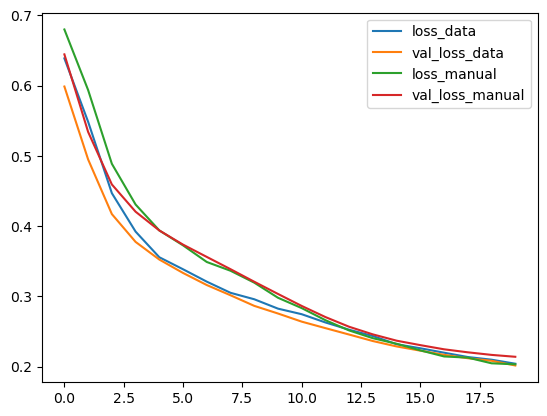

In [39]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

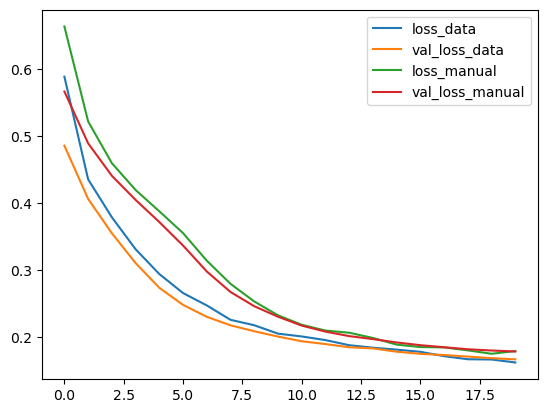

In [40]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data_bn['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_bn['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_bn['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_bn['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

Iterative prunning

In [41]:
model_data_it     = NeuralNet1(22).to(device)
model_manual_it   = NeuralNet1(11).to(device)
model_data_it_bn     = NeuralNetBN(22).to(device)
model_manual_it_bn   = NeuralNetBN(11).to(device)

In [42]:
module_data_it = model_data_it.features[2]
module_manual_it = model_manual_it.features[2]
module_data_it_bn = model_data_it_bn.features[3]
module_manual_it_bn = model_manual_it_bn.features[3]

In [43]:
prune.ln_structured(module_data_it, name="weight", amount=0.5, n=3, dim=0)
prune.ln_structured(module_manual_it, name="weight", amount=0.5, n=3, dim=0)
prune.ln_structured(module_data_it_bn, name="weight", amount=0.5, n=3, dim=0)
prune.ln_structured(module_manual_it_bn, name="weight", amount=0.5, n=3, dim=0)

Linear(in_features=20, out_features=5, bias=True)

In [44]:
traintest_data_it = TrainTestModel(model_data_it)
traintest_manual_it = TrainTestModel(model_manual_it)
traintest_data_it_bn = TrainTestModel(model_data_it_bn)
traintest_manual_it_bn = TrainTestModel(model_manual_it_bn)

traintest_data_it.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.794 | train acc: 44.238%
[epoch 0] recall: 1.000 | precision: 0.442
[epoch 0] train loss: 0.788 | train acc: 43.691%
[epoch 0] recall: 1.000 | precision: 0.437
[epoch 0] train loss: 0.778 | train acc: 43.926%
[epoch 0] recall: 1.000 | precision: 0.439
[epoch 0] train loss: 0.770 | train acc: 43.790%
[epoch 0] recall: 1.000 | precision: 0.438
[epoch 0] test loss: 0.736 | test acc: 43.720%
[epoch 0] test recall: 1.000 | test precision: 0.437
[epoch 1] train loss: 0.730 | train acc: 42.988%
[epoch 1] recall: 1.000 | precision: 0.430
[epoch 1] train loss: 0.715 | train acc: 43.613%
[epoch 1] recall: 1.000 | precision: 0.436
[epoch 1] train loss: 0.701 | train acc: 43.978%
[epoch 1] recall: 1.000 | precision: 0.440
[epoch 1] train loss: 0.688 | train acc: 44.360%
[epoch 1] recall: 0.998 | precision: 0.440
[epoch 1] test loss: 0.629 | test acc: 50.560%
[epoch 1] test recall: 0.976 | test precision: 0.469
[epoch 2] train loss: 0.608 | train acc: 55.449%
[epoch 2] recal

[epoch 17] train loss: 0.213 | train acc: 91.341%
[epoch 17] recall: 0.885 | precision: 0.914
[epoch 17] train loss: 0.211 | train acc: 91.415%
[epoch 17] recall: 0.887 | precision: 0.914
[epoch 17] test loss: 0.205 | test acc: 91.940%
[epoch 17] test recall: 0.896 | test precision: 0.918
[epoch 18] train loss: 0.208 | train acc: 91.445%
[epoch 18] recall: 0.876 | precision: 0.922
[epoch 18] train loss: 0.199 | train acc: 92.080%
[epoch 18] recall: 0.892 | precision: 0.922
[epoch 18] train loss: 0.201 | train acc: 91.849%
[epoch 18] recall: 0.890 | precision: 0.919
[epoch 18] train loss: 0.204 | train acc: 91.715%
[epoch 18] recall: 0.889 | precision: 0.919
[epoch 18] test loss: 0.200 | test acc: 92.040%
[epoch 18] test recall: 0.911 | test precision: 0.907
[epoch 19] train loss: 0.199 | train acc: 92.168%
[epoch 19] recall: 0.906 | precision: 0.917
[epoch 19] train loss: 0.203 | train acc: 91.875%
[epoch 19] recall: 0.893 | precision: 0.919
[epoch 19] train loss: 0.200 | train acc: 92

In [45]:
traintest_manual_it.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.685 | train acc: 55.664%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] train loss: 0.681 | train acc: 56.104%
[epoch 0] recall: 0.003 | precision: 0.591
[epoch 0] train loss: 0.676 | train acc: 57.878%
[epoch 0] recall: 0.042 | precision: 0.865
[epoch 0] train loss: 0.672 | train acc: 60.025%
[epoch 0] recall: 0.109 | precision: 0.834
[epoch 0] test loss: 0.647 | test acc: 72.560%
[epoch 0] test recall: 0.477 | test precision: 0.816
[epoch 1] train loss: 0.639 | train acc: 75.352%
[epoch 1] recall: 0.563 | precision: 0.819
[epoch 1] train loss: 0.628 | train acc: 76.758%
[epoch 1] recall: 0.622 | precision: 0.800
[epoch 1] train loss: 0.615 | train acc: 77.266%
[epoch 1] recall: 0.667 | precision: 0.784
[epoch 1] train loss: 0.605 | train acc: 77.275%
[epoch 1] recall: 0.691 | precision: 0.767
[epoch 1] test loss: 0.553 | test acc: 78.100%
[epoch 1] test recall: 0.798 | test precision: 0.726
[epoch 2] train loss: 0.538 | train acc: 78.984%
[epoch 2] recal

[epoch 17] train loss: 0.214 | train acc: 91.504%
[epoch 17] recall: 0.885 | precision: 0.917
[epoch 17] train loss: 0.216 | train acc: 91.470%
[epoch 17] recall: 0.883 | precision: 0.919
[epoch 17] test loss: 0.220 | test acc: 91.080%
[epoch 17] test recall: 0.876 | test precision: 0.916
[epoch 18] train loss: 0.203 | train acc: 91.973%
[epoch 18] recall: 0.886 | precision: 0.924
[epoch 18] train loss: 0.203 | train acc: 91.865%
[epoch 18] recall: 0.885 | precision: 0.923
[epoch 18] train loss: 0.206 | train acc: 91.849%
[epoch 18] recall: 0.886 | precision: 0.924
[epoch 18] train loss: 0.207 | train acc: 91.680%
[epoch 18] recall: 0.887 | precision: 0.921
[epoch 18] test loss: 0.216 | test acc: 91.160%
[epoch 18] test recall: 0.883 | test precision: 0.911
[epoch 19] train loss: 0.206 | train acc: 91.445%
[epoch 19] recall: 0.885 | precision: 0.918
[epoch 19] train loss: 0.206 | train acc: 91.689%
[epoch 19] recall: 0.886 | precision: 0.923
[epoch 19] train loss: 0.205 | train acc: 91

In [46]:
traintest_data_it_bn.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.705 | train acc: 44.473%
[epoch 0] recall: 0.407 | precision: 0.373
[epoch 0] train loss: 0.681 | train acc: 50.859%
[epoch 0] recall: 0.460 | precision: 0.432
[epoch 0] train loss: 0.661 | train acc: 56.660%
[epoch 0] recall: 0.516 | precision: 0.501
[epoch 0] train loss: 0.645 | train acc: 60.730%
[epoch 0] recall: 0.554 | precision: 0.551
[epoch 0] test loss: 0.572 | test acc: 76.500%
[epoch 0] test recall: 0.705 | test precision: 0.744
[epoch 1] train loss: 0.567 | train acc: 76.934%
[epoch 1] recall: 0.703 | precision: 0.757
[epoch 1] train loss: 0.556 | train acc: 78.926%
[epoch 1] recall: 0.725 | precision: 0.782
[epoch 1] train loss: 0.546 | train acc: 80.150%
[epoch 1] recall: 0.735 | precision: 0.795
[epoch 1] train loss: 0.537 | train acc: 81.195%
[epoch 1] recall: 0.746 | precision: 0.810
[epoch 1] test loss: 0.497 | test acc: 84.700%
[epoch 1] test recall: 0.785 | test precision: 0.853
[epoch 2] train loss: 0.487 | train acc: 85.762%
[epoch 2] recal

[epoch 17] train loss: 0.169 | train acc: 93.490%
[epoch 17] recall: 0.919 | precision: 0.932
[epoch 17] train loss: 0.170 | train acc: 93.450%
[epoch 17] recall: 0.916 | precision: 0.933
[epoch 17] test loss: 0.174 | test acc: 93.120%
[epoch 17] test recall: 0.902 | test precision: 0.938
[epoch 18] train loss: 0.171 | train acc: 93.594%
[epoch 18] recall: 0.918 | precision: 0.931
[epoch 18] train loss: 0.173 | train acc: 93.506%
[epoch 18] recall: 0.912 | precision: 0.937
[epoch 18] train loss: 0.170 | train acc: 93.477%
[epoch 18] recall: 0.912 | precision: 0.937
[epoch 18] train loss: 0.173 | train acc: 93.590%
[epoch 18] recall: 0.914 | precision: 0.938
[epoch 18] test loss: 0.171 | test acc: 92.980%
[epoch 18] test recall: 0.905 | test precision: 0.933
[epoch 19] train loss: 0.160 | train acc: 93.906%
[epoch 19] recall: 0.926 | precision: 0.930
[epoch 19] train loss: 0.167 | train acc: 93.486%
[epoch 19] recall: 0.915 | precision: 0.933
[epoch 19] train loss: 0.166 | train acc: 93

In [47]:
traintest_manual_it_bn.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.663 | train acc: 56.270%
[epoch 0] recall: 0.437 | precision: 0.496
[epoch 0] train loss: 0.655 | train acc: 58.643%
[epoch 0] recall: 0.426 | precision: 0.529
[epoch 0] train loss: 0.648 | train acc: 61.452%
[epoch 0] recall: 0.430 | precision: 0.575
[epoch 0] train loss: 0.643 | train acc: 63.540%
[epoch 0] recall: 0.446 | precision: 0.615
[epoch 0] test loss: 0.615 | test acc: 73.340%
[epoch 0] test recall: 0.540 | test precision: 0.780
[epoch 1] train loss: 0.607 | train acc: 75.078%
[epoch 1] recall: 0.569 | precision: 0.791
[epoch 1] train loss: 0.602 | train acc: 76.016%
[epoch 1] recall: 0.579 | precision: 0.823
[epoch 1] train loss: 0.595 | train acc: 77.331%
[epoch 1] recall: 0.598 | precision: 0.838
[epoch 1] train loss: 0.586 | train acc: 78.325%
[epoch 1] recall: 0.617 | precision: 0.846
[epoch 1] test loss: 0.555 | test acc: 82.200%
[epoch 1] test recall: 0.689 | test precision: 0.875
[epoch 2] train loss: 0.543 | train acc: 84.238%
[epoch 2] recal

[epoch 17] train loss: 0.189 | train acc: 92.721%
[epoch 17] recall: 0.907 | precision: 0.925
[epoch 17] train loss: 0.187 | train acc: 92.850%
[epoch 17] recall: 0.909 | precision: 0.927
[epoch 17] test loss: 0.189 | test acc: 92.300%
[epoch 17] test recall: 0.910 | test precision: 0.913
[epoch 18] train loss: 0.189 | train acc: 92.109%
[epoch 18] recall: 0.913 | precision: 0.909
[epoch 18] train loss: 0.187 | train acc: 92.314%
[epoch 18] recall: 0.909 | precision: 0.914
[epoch 18] train loss: 0.186 | train acc: 92.409%
[epoch 18] recall: 0.906 | precision: 0.920
[epoch 18] train loss: 0.183 | train acc: 92.600%
[epoch 18] recall: 0.909 | precision: 0.921
[epoch 18] test loss: 0.187 | test acc: 92.580%
[epoch 18] test recall: 0.908 | test precision: 0.921
[epoch 19] train loss: 0.190 | train acc: 92.285%
[epoch 19] recall: 0.900 | precision: 0.920
[epoch 19] train loss: 0.183 | train acc: 92.783%
[epoch 19] recall: 0.906 | precision: 0.927
[epoch 19] train loss: 0.179 | train acc: 92

In [48]:
history_data_it = traintest_data_it.get_history()
history_manual_it = traintest_manual_it.get_history()
history_data_it_bn = traintest_data_it_bn.get_history()
history_manual_it_bn = traintest_manual_it_bn.get_history()

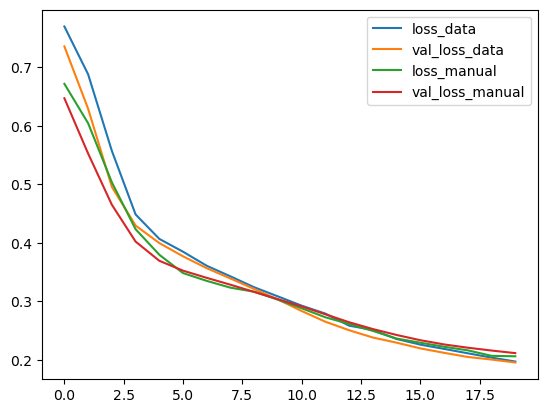

In [49]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data_it['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_it['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_it['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_it['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

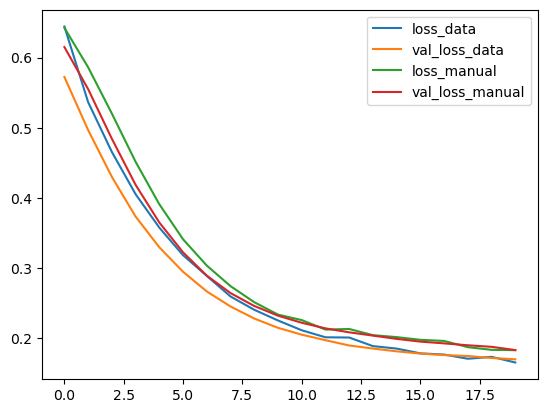

In [50]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data_it_bn['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_it_bn['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_it_bn['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_it_bn['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

Pruning multiple parameters

In [51]:
def pruneAllLayers(model):
    for name, module in model.named_modules():
        # prune 40% of all Linear layers 
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=0.4)

In [52]:
model_data_all     = NeuralNet1(22).to(device)
model_manual_all   = NeuralNet1(11).to(device)
model_data_all_bn     = NeuralNetBN(22).to(device)
model_manual_all_bn   = NeuralNetBN(11).to(device)

pruneAllLayers(model_data_all)
pruneAllLayers(model_manual_all)
pruneAllLayers(model_data_all_bn)
pruneAllLayers(model_manual_all_bn)

print(dict(model_data_all.named_buffers()).keys())  # to verify that all masks exist
print(dict(model_manual_all.named_buffers()).keys())  # to verify that all masks exist
print(dict(model_data_all_bn.named_buffers()).keys())  # to verify that all masks exist
print(dict(model_manual_all_bn.named_buffers()).keys())  # to verify that all masks exist

dict_keys(['features.ln1.weight_mask', 'features.ln2.weight_mask', 'features.ln3.weight_mask'])
dict_keys(['features.ln1.weight_mask', 'features.ln2.weight_mask', 'features.ln3.weight_mask'])
dict_keys(['features.ln1.weight_mask', 'features.bn1.running_mean', 'features.bn1.running_var', 'features.bn1.num_batches_tracked', 'features.ln2.weight_mask', 'features.bn2.running_mean', 'features.bn2.running_var', 'features.bn2.num_batches_tracked', 'features.ln3.weight_mask'])
dict_keys(['features.ln1.weight_mask', 'features.bn1.running_mean', 'features.bn1.running_var', 'features.bn1.num_batches_tracked', 'features.ln2.weight_mask', 'features.bn2.running_mean', 'features.bn2.running_var', 'features.bn2.num_batches_tracked', 'features.ln3.weight_mask'])


In [53]:
traintest_data_all = TrainTestModel(model_data_all)
traintest_manual_all = TrainTestModel(model_manual_all)
traintest_data_all_bn = TrainTestModel(model_data_all_bn)
traintest_manual_all_bn = TrainTestModel(model_manual_all_bn)

traintest_data_all.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.826 | train acc: 43.281%
[epoch 0] recall: 1.000 | precision: 0.433
[epoch 0] train loss: 0.817 | train acc: 43.691%
[epoch 0] recall: 1.000 | precision: 0.437
[epoch 0] train loss: 0.812 | train acc: 43.620%
[epoch 0] recall: 1.000 | precision: 0.436
[epoch 0] train loss: 0.804 | train acc: 43.790%
[epoch 0] recall: 1.000 | precision: 0.438
[epoch 0] test loss: 0.782 | test acc: 43.720%
[epoch 0] test recall: 1.000 | test precision: 0.437
[epoch 1] train loss: 0.775 | train acc: 43.672%
[epoch 1] recall: 1.000 | precision: 0.437
[epoch 1] train loss: 0.768 | train acc: 43.584%
[epoch 1] recall: 1.000 | precision: 0.436
[epoch 1] train loss: 0.756 | train acc: 44.128%
[epoch 1] recall: 1.000 | precision: 0.441
[epoch 1] train loss: 0.746 | train acc: 43.820%
[epoch 1] recall: 0.999 | precision: 0.438
[epoch 1] test loss: 0.705 | test acc: 44.580%
[epoch 1] test recall: 0.989 | test precision: 0.440
[epoch 2] train loss: 0.686 | train acc: 48.105%
[epoch 2] recal

[epoch 17] train loss: 0.262 | train acc: 89.993%
[epoch 17] recall: 0.875 | precision: 0.894
[epoch 17] train loss: 0.261 | train acc: 89.990%
[epoch 17] recall: 0.874 | precision: 0.895
[epoch 17] test loss: 0.255 | test acc: 90.160%
[epoch 17] test recall: 0.882 | test precision: 0.891
[epoch 18] train loss: 0.234 | train acc: 91.309%
[epoch 18] recall: 0.900 | precision: 0.898
[epoch 18] train loss: 0.240 | train acc: 91.045%
[epoch 18] recall: 0.891 | precision: 0.900
[epoch 18] train loss: 0.246 | train acc: 90.703%
[epoch 18] recall: 0.884 | precision: 0.900
[epoch 18] train loss: 0.246 | train acc: 90.460%
[epoch 18] recall: 0.880 | precision: 0.900
[epoch 18] test loss: 0.243 | test acc: 90.740%
[epoch 18] test recall: 0.893 | test precision: 0.895
[epoch 19] train loss: 0.233 | train acc: 90.801%
[epoch 19] recall: 0.886 | precision: 0.901
[epoch 19] train loss: 0.235 | train acc: 90.908%
[epoch 19] recall: 0.885 | precision: 0.905
[epoch 19] train loss: 0.237 | train acc: 90

In [54]:
traintest_manual_all.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.682 | train acc: 55.801%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] train loss: 0.676 | train acc: 56.377%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] train loss: 0.673 | train acc: 56.159%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] train loss: 0.669 | train acc: 56.210%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] test loss: 0.649 | test acc: 56.460%
[epoch 0] test recall: 0.000 | test precision: 0.000
[epoch 1] train loss: 0.645 | train acc: 55.840%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] train loss: 0.639 | train acc: 57.139%
[epoch 1] recall: 0.023 | precision: 1.000
[epoch 1] train loss: 0.633 | train acc: 60.410%
[epoch 1] recall: 0.100 | precision: 0.994
[epoch 1] train loss: 0.624 | train acc: 64.215%
[epoch 1] recall: 0.189 | precision: 0.968
[epoch 1] test loss: 0.594 | test acc: 79.320%
[epoch 1] test recall: 0.569 | test precision: 0.929
[epoch 2] train loss: 0.584 | train acc: 80.605%
[epoch 2] recal

[epoch 17] train loss: 0.249 | train acc: 90.423%
[epoch 17] recall: 0.872 | precision: 0.905
[epoch 17] train loss: 0.248 | train acc: 90.410%
[epoch 17] recall: 0.873 | precision: 0.905
[epoch 17] test loss: 0.252 | test acc: 89.860%
[epoch 17] test recall: 0.871 | test precision: 0.893
[epoch 18] train loss: 0.235 | train acc: 91.113%
[epoch 18] recall: 0.881 | precision: 0.915
[epoch 18] train loss: 0.234 | train acc: 91.045%
[epoch 18] recall: 0.882 | precision: 0.911
[epoch 18] train loss: 0.238 | train acc: 90.833%
[epoch 18] recall: 0.879 | precision: 0.908
[epoch 18] train loss: 0.236 | train acc: 90.855%
[epoch 18] recall: 0.879 | precision: 0.909
[epoch 18] test loss: 0.243 | test acc: 90.400%
[epoch 18] test recall: 0.879 | test precision: 0.898
[epoch 19] train loss: 0.224 | train acc: 91.328%
[epoch 19] recall: 0.884 | precision: 0.906
[epoch 19] train loss: 0.228 | train acc: 91.182%
[epoch 19] recall: 0.881 | precision: 0.913
[epoch 19] train loss: 0.233 | train acc: 91

In [55]:
traintest_data_all_bn.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.751 | train acc: 43.965%
[epoch 0] recall: 1.000 | precision: 0.440
[epoch 0] train loss: 0.739 | train acc: 43.496%
[epoch 0] recall: 1.000 | precision: 0.435
[epoch 0] train loss: 0.724 | train acc: 44.056%
[epoch 0] recall: 0.999 | precision: 0.440
[epoch 0] train loss: 0.713 | train acc: 44.260%
[epoch 0] recall: 0.996 | precision: 0.440
[epoch 0] test loss: 0.667 | test acc: 48.140%
[epoch 0] test recall: 0.977 | test precision: 0.457
[epoch 1] train loss: 0.658 | train acc: 51.016%
[epoch 1] recall: 0.972 | precision: 0.472
[epoch 1] train loss: 0.648 | train acc: 54.463%
[epoch 1] recall: 0.960 | precision: 0.491
[epoch 1] train loss: 0.640 | train acc: 57.611%
[epoch 1] recall: 0.947 | precision: 0.509
[epoch 1] train loss: 0.630 | train acc: 60.835%
[epoch 1] recall: 0.935 | precision: 0.530
[epoch 1] test loss: 0.592 | test acc: 73.720%
[epoch 1] test recall: 0.874 | test precision: 0.648
[epoch 2] train loss: 0.581 | train acc: 76.855%
[epoch 2] recal

[epoch 17] train loss: 0.188 | train acc: 92.734%
[epoch 17] recall: 0.903 | precision: 0.929
[epoch 17] train loss: 0.187 | train acc: 92.810%
[epoch 17] recall: 0.905 | precision: 0.929
[epoch 17] test loss: 0.183 | test acc: 92.900%
[epoch 17] test recall: 0.903 | test precision: 0.933
[epoch 18] train loss: 0.197 | train acc: 92.324%
[epoch 18] recall: 0.893 | precision: 0.933
[epoch 18] train loss: 0.188 | train acc: 92.705%
[epoch 18] recall: 0.902 | precision: 0.929
[epoch 18] train loss: 0.186 | train acc: 92.819%
[epoch 18] recall: 0.905 | precision: 0.929
[epoch 18] train loss: 0.184 | train acc: 92.830%
[epoch 18] recall: 0.905 | precision: 0.930
[epoch 18] test loss: 0.180 | test acc: 93.060%
[epoch 18] test recall: 0.904 | test precision: 0.935
[epoch 19] train loss: 0.177 | train acc: 93.516%
[epoch 19] recall: 0.912 | precision: 0.939
[epoch 19] train loss: 0.179 | train acc: 93.398%
[epoch 19] recall: 0.908 | precision: 0.940
[epoch 19] train loss: 0.182 | train acc: 93

In [56]:
traintest_manual_all_bn.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.624 | train acc: 70.254%
[epoch 0] recall: 0.462 | precision: 0.771
[epoch 0] train loss: 0.603 | train acc: 72.705%
[epoch 0] recall: 0.506 | precision: 0.791
[epoch 0] train loss: 0.590 | train acc: 74.551%
[epoch 0] recall: 0.540 | precision: 0.815
[epoch 0] train loss: 0.577 | train acc: 75.815%
[epoch 0] recall: 0.566 | precision: 0.827
[epoch 0] test loss: 0.525 | test acc: 80.580%
[epoch 0] test recall: 0.672 | test precision: 0.851
[epoch 1] train loss: 0.513 | train acc: 81.328%
[epoch 1] recall: 0.682 | precision: 0.866
[epoch 1] train loss: 0.508 | train acc: 81.113%
[epoch 1] recall: 0.684 | precision: 0.857
[epoch 1] train loss: 0.501 | train acc: 81.576%
[epoch 1] recall: 0.691 | precision: 0.862
[epoch 1] train loss: 0.489 | train acc: 82.180%
[epoch 1] recall: 0.702 | precision: 0.866
[epoch 1] test loss: 0.460 | test acc: 83.900%
[epoch 1] test recall: 0.729 | test precision: 0.880
[epoch 2] train loss: 0.453 | train acc: 83.770%
[epoch 2] recal

[epoch 17] train loss: 0.194 | train acc: 92.070%
[epoch 17] recall: 0.895 | precision: 0.922
[epoch 17] train loss: 0.193 | train acc: 92.160%
[epoch 17] recall: 0.896 | precision: 0.923
[epoch 17] test loss: 0.193 | test acc: 92.180%
[epoch 17] test recall: 0.894 | test precision: 0.924
[epoch 18] train loss: 0.184 | train acc: 92.578%
[epoch 18] recall: 0.900 | precision: 0.928
[epoch 18] train loss: 0.185 | train acc: 92.695%
[epoch 18] recall: 0.903 | precision: 0.929
[epoch 18] train loss: 0.189 | train acc: 92.448%
[epoch 18] recall: 0.900 | precision: 0.927
[epoch 18] train loss: 0.189 | train acc: 92.370%
[epoch 18] recall: 0.900 | precision: 0.923
[epoch 18] test loss: 0.190 | test acc: 92.420%
[epoch 18] test recall: 0.898 | test precision: 0.925
[epoch 19] train loss: 0.181 | train acc: 92.793%
[epoch 19] recall: 0.900 | precision: 0.934
[epoch 19] train loss: 0.184 | train acc: 92.617%
[epoch 19] recall: 0.901 | precision: 0.929
[epoch 19] train loss: 0.185 | train acc: 92

In [57]:
history_data_all = traintest_data_all.get_history()
history_manual_all = traintest_manual_all.get_history()
history_data_all_bn = traintest_data_all_bn.get_history()
history_manual_all_bn = traintest_manual_all_bn.get_history()

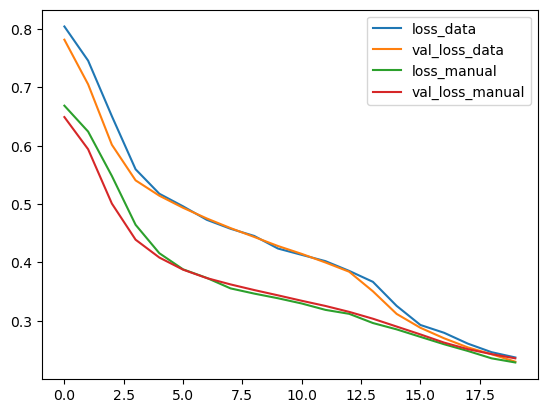

In [58]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data_all['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_all['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_all['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_all['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

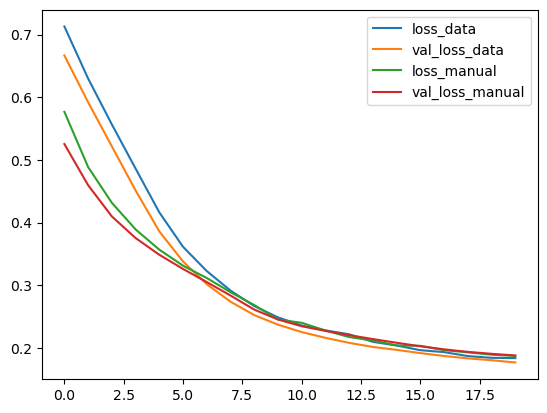

In [59]:
plt.plot(pd.DataFrame(history_data_all_bn['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_all_bn['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_all_bn['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_all_bn['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

Global pruning

In [60]:
model_data_global        = NeuralNet1(22).to(device)
model_manual_global      = NeuralNet1(11).to(device)
model_data_global_bn     = NeuralNetBN(22).to(device)
model_manual_global_bn   = NeuralNetBN(11).to(device)

print(model_data_global.features)
print(model_data_global_bn.features)

Sequential(
  (ln1): Linear(in_features=22, out_features=20, bias=True)
  (relu1): ReLU(inplace=True)
  (ln2): Linear(in_features=20, out_features=5, bias=True)
  (relu2): ReLU(inplace=True)
  (ln3): Linear(in_features=5, out_features=2, bias=True)
)
Sequential(
  (ln1): Linear(in_features=22, out_features=20, bias=True)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (ln2): Linear(in_features=20, out_features=5, bias=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (ln3): Linear(in_features=5, out_features=2, bias=True)
)


In [61]:
def get_global_prune_parameters(model):
    return ((model.features[0], 'weight'),
        (model.features[2], 'weight'),
        (model.features[4], 'weight'))

def get_global_prune_parameters_bn(model):
    return ((model.features[0], 'weight'),
        (model.features[3], 'weight'),
        (model.features[6], 'weight'))

In [62]:
prune.global_unstructured(
    get_global_prune_parameters(model_data_global),
    pruning_method=prune.L1Unstructured,
    amount=0.4
)

prune.global_unstructured(
    get_global_prune_parameters(model_manual_global),
    pruning_method=prune.L1Unstructured,
    amount=0.4
)

prune.global_unstructured(
    get_global_prune_parameters_bn(model_data_global_bn),
    pruning_method=prune.L1Unstructured,
    amount=0.4
)

prune.global_unstructured(
    get_global_prune_parameters_bn(model_manual_global_bn),
    pruning_method=prune.L1Unstructured,
    amount=0.4
)

Now we can check the sparsity induced in every pruned parameter, which will not be equal to 40% in each layer. 
However, the global sparsity will be (approximately) 40%.

In [63]:
def check_sparsity(model):
    print(
        "Sparsity in ln1.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[0].weight == 0))
            / float(model.features[0].weight.nelement())
        )
    )
    print(
        "Sparsity in ln2.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[2].weight == 0))
            / float(model.features[2].weight.nelement())
        )
    )
    print(
        "Sparsity in ln3.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[4].weight == 0))
            / float(model.features[4].weight.nelement())
        )
    )

    print(
        "Global sparsity: {:.2f}%".format(
            100. * float(
                torch.sum(model.features[0].weight == 0)
                + torch.sum(model.features[2].weight == 0)
                + torch.sum(model.features[4].weight == 0)
            )
            / float(
                model.features[0].weight.nelement()
                + model.features[2].weight.nelement()
                + model.features[4].weight.nelement()
            )
        )
    )

In [64]:
check_sparsity(model_data_global)
check_sparsity(model_manual_global)

Sparsity in ln1.weight: 40.91%
Sparsity in ln2.weight: 39.00%
Sparsity in ln3.weight: 10.00%
Global sparsity: 40.00%
Sparsity in ln1.weight: 35.45%
Sparsity in ln2.weight: 49.00%
Sparsity in ln3.weight: 50.00%
Global sparsity: 40.00%


In [65]:
traintest_data_global = TrainTestModel(model_data_global)
traintest_manual_global = TrainTestModel(model_manual_global)
traintest_data_global_bn = TrainTestModel(model_data_global_bn)
traintest_manual_global_bn = TrainTestModel(model_manual_global_bn)

traintest_data_global.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.734 | train acc: 45.234%
[epoch 0] recall: 1.000 | precision: 0.452
[epoch 0] train loss: 0.733 | train acc: 44.746%
[epoch 0] recall: 1.000 | precision: 0.448
[epoch 0] train loss: 0.732 | train acc: 44.225%
[epoch 0] recall: 1.000 | precision: 0.442
[epoch 0] train loss: 0.730 | train acc: 43.790%
[epoch 0] recall: 1.000 | precision: 0.438
[epoch 0] test loss: 0.712 | test acc: 43.780%
[epoch 0] test recall: 0.999 | test precision: 0.437
[epoch 1] train loss: 0.706 | train acc: 43.457%
[epoch 1] recall: 0.998 | precision: 0.434
[epoch 1] train loss: 0.697 | train acc: 44.043%
[epoch 1] recall: 0.996 | precision: 0.437
[epoch 1] train loss: 0.684 | train acc: 45.938%
[epoch 1] recall: 0.987 | precision: 0.447
[epoch 1] train loss: 0.669 | train acc: 49.385%
[epoch 1] recall: 0.975 | precision: 0.463
[epoch 1] test loss: 0.607 | test acc: 66.980%
[epoch 1] test recall: 0.898 | test precision: 0.579
[epoch 2] train loss: 0.596 | train acc: 70.742%
[epoch 2] recal

[epoch 17] train loss: 0.223 | train acc: 90.996%
[epoch 17] recall: 0.876 | precision: 0.914
[epoch 17] train loss: 0.225 | train acc: 90.975%
[epoch 17] recall: 0.878 | precision: 0.913
[epoch 17] test loss: 0.221 | test acc: 91.440%
[epoch 17] test recall: 0.897 | test precision: 0.906
[epoch 18] train loss: 0.218 | train acc: 91.055%
[epoch 18] recall: 0.899 | precision: 0.901
[epoch 18] train loss: 0.216 | train acc: 91.260%
[epoch 18] recall: 0.889 | precision: 0.913
[epoch 18] train loss: 0.217 | train acc: 91.152%
[epoch 18] recall: 0.882 | precision: 0.914
[epoch 18] train loss: 0.217 | train acc: 91.160%
[epoch 18] recall: 0.881 | precision: 0.914
[epoch 18] test loss: 0.213 | test acc: 91.500%
[epoch 18] test recall: 0.888 | test precision: 0.915
[epoch 19] train loss: 0.211 | train acc: 91.211%
[epoch 19] recall: 0.886 | precision: 0.912
[epoch 19] train loss: 0.215 | train acc: 91.367%
[epoch 19] recall: 0.888 | precision: 0.914
[epoch 19] train loss: 0.212 | train acc: 91

In [66]:
traintest_manual_global.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.681 | train acc: 55.645%
[epoch 0] recall: 0.000 | precision: 1.000
[epoch 0] train loss: 0.677 | train acc: 56.396%
[epoch 0] recall: 0.003 | precision: 1.000
[epoch 0] train loss: 0.673 | train acc: 57.370%
[epoch 0] recall: 0.029 | precision: 0.990
[epoch 0] train loss: 0.668 | train acc: 59.485%
[epoch 0] recall: 0.076 | precision: 0.982
[epoch 0] test loss: 0.649 | test acc: 70.280%
[epoch 0] test recall: 0.330 | test precision: 0.964
[epoch 1] train loss: 0.643 | train acc: 73.555%
[epoch 1] recall: 0.414 | precision: 0.936
[epoch 1] train loss: 0.636 | train acc: 75.898%
[epoch 1] recall: 0.491 | precision: 0.916
[epoch 1] train loss: 0.628 | train acc: 77.845%
[epoch 1] recall: 0.560 | precision: 0.896
[epoch 1] train loss: 0.619 | train acc: 79.135%
[epoch 1] recall: 0.607 | precision: 0.879
[epoch 1] test loss: 0.586 | test acc: 82.920%
[epoch 1] test recall: 0.792 | test precision: 0.811
[epoch 2] train loss: 0.574 | train acc: 83.809%
[epoch 2] recal

[epoch 17] train loss: 0.245 | train acc: 90.234%
[epoch 17] recall: 0.871 | precision: 0.903
[epoch 17] train loss: 0.244 | train acc: 90.260%
[epoch 17] recall: 0.871 | precision: 0.903
[epoch 17] test loss: 0.252 | test acc: 89.880%
[epoch 17] test recall: 0.869 | test precision: 0.895
[epoch 18] train loss: 0.232 | train acc: 90.820%
[epoch 18] recall: 0.870 | precision: 0.918
[epoch 18] train loss: 0.236 | train acc: 90.605%
[epoch 18] recall: 0.877 | precision: 0.908
[epoch 18] train loss: 0.237 | train acc: 90.618%
[epoch 18] recall: 0.880 | precision: 0.905
[epoch 18] train loss: 0.238 | train acc: 90.560%
[epoch 18] recall: 0.877 | precision: 0.904
[epoch 18] test loss: 0.246 | test acc: 90.100%
[epoch 18] test recall: 0.864 | test precision: 0.904
[epoch 19] train loss: 0.231 | train acc: 91.035%
[epoch 19] recall: 0.870 | precision: 0.917
[epoch 19] train loss: 0.234 | train acc: 90.869%
[epoch 19] recall: 0.875 | precision: 0.912
[epoch 19] train loss: 0.232 | train acc: 90

In [67]:
traintest_data_global_bn.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.711 | train acc: 52.520%
[epoch 0] recall: 0.408 | precision: 0.445
[epoch 0] train loss: 0.687 | train acc: 57.480%
[epoch 0] recall: 0.452 | precision: 0.517
[epoch 0] train loss: 0.666 | train acc: 61.139%
[epoch 0] recall: 0.485 | precision: 0.562
[epoch 0] train loss: 0.650 | train acc: 63.830%
[epoch 0] recall: 0.510 | precision: 0.603
[epoch 0] test loss: 0.590 | test acc: 73.420%
[epoch 0] test recall: 0.598 | test precision: 0.744
[epoch 1] train loss: 0.575 | train acc: 75.625%
[epoch 1] recall: 0.625 | precision: 0.774
[epoch 1] train loss: 0.566 | train acc: 76.445%
[epoch 1] recall: 0.637 | precision: 0.783
[epoch 1] train loss: 0.557 | train acc: 77.031%
[epoch 1] recall: 0.644 | precision: 0.792
[epoch 1] train loss: 0.548 | train acc: 77.755%
[epoch 1] recall: 0.651 | precision: 0.804
[epoch 1] test loss: 0.516 | test acc: 79.980%
[epoch 1] test recall: 0.678 | test precision: 0.833
[epoch 2] train loss: 0.505 | train acc: 80.840%
[epoch 2] recal

[epoch 17] train loss: 0.194 | train acc: 91.901%
[epoch 17] recall: 0.889 | precision: 0.921
[epoch 17] train loss: 0.195 | train acc: 91.990%
[epoch 17] recall: 0.888 | precision: 0.926
[epoch 17] test loss: 0.197 | test acc: 91.880%
[epoch 17] test recall: 0.884 | test precision: 0.927
[epoch 18] train loss: 0.187 | train acc: 91.895%
[epoch 18] recall: 0.884 | precision: 0.931
[epoch 18] train loss: 0.190 | train acc: 92.041%
[epoch 18] recall: 0.891 | precision: 0.926
[epoch 18] train loss: 0.192 | train acc: 91.940%
[epoch 18] recall: 0.890 | precision: 0.923
[epoch 18] train loss: 0.187 | train acc: 92.165%
[epoch 18] recall: 0.891 | precision: 0.927
[epoch 18] test loss: 0.196 | test acc: 91.840%
[epoch 18] test recall: 0.885 | test precision: 0.925
[epoch 19] train loss: 0.190 | train acc: 92.344%
[epoch 19] recall: 0.898 | precision: 0.925
[epoch 19] train loss: 0.192 | train acc: 92.021%
[epoch 19] recall: 0.897 | precision: 0.917
[epoch 19] train loss: 0.189 | train acc: 92

In [68]:
traintest_manual_global_bn.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.965 | train acc: 42.988%
[epoch 0] recall: 1.000 | precision: 0.430
[epoch 0] train loss: 0.927 | train acc: 43.604%
[epoch 0] recall: 1.000 | precision: 0.436
[epoch 0] train loss: 0.894 | train acc: 43.822%
[epoch 0] recall: 1.000 | precision: 0.438
[epoch 0] train loss: 0.868 | train acc: 43.790%
[epoch 0] recall: 1.000 | precision: 0.438
[epoch 0] test loss: 0.772 | test acc: 43.540%
[epoch 0] test recall: 1.000 | test precision: 0.435
[epoch 1] train loss: 0.767 | train acc: 42.598%
[epoch 1] recall: 1.000 | precision: 0.426
[epoch 1] train loss: 0.744 | train acc: 43.145%
[epoch 1] recall: 1.000 | precision: 0.431
[epoch 1] train loss: 0.729 | train acc: 43.451%
[epoch 1] recall: 1.000 | precision: 0.435
[epoch 1] train loss: 0.713 | train acc: 43.795%
[epoch 1] recall: 1.000 | precision: 0.438
[epoch 1] test loss: 0.679 | test acc: 43.620%
[epoch 1] test recall: 1.000 | test precision: 0.436
[epoch 2] train loss: 0.674 | train acc: 42.871%
[epoch 2] recal

[epoch 17] train loss: 0.207 | train acc: 92.188%
[epoch 17] recall: 0.903 | precision: 0.917
[epoch 17] train loss: 0.206 | train acc: 92.290%
[epoch 17] recall: 0.903 | precision: 0.920
[epoch 17] test loss: 0.207 | test acc: 92.380%
[epoch 17] test recall: 0.907 | test precision: 0.917
[epoch 18] train loss: 0.202 | train acc: 92.715%
[epoch 18] recall: 0.906 | precision: 0.924
[epoch 18] train loss: 0.203 | train acc: 92.451%
[epoch 18] recall: 0.904 | precision: 0.923
[epoch 18] train loss: 0.202 | train acc: 92.370%
[epoch 18] recall: 0.904 | precision: 0.921
[epoch 18] train loss: 0.200 | train acc: 92.400%
[epoch 18] recall: 0.906 | precision: 0.919
[epoch 18] test loss: 0.202 | test acc: 92.480%
[epoch 18] test recall: 0.909 | test precision: 0.918
[epoch 19] train loss: 0.199 | train acc: 92.500%
[epoch 19] recall: 0.906 | precision: 0.924
[epoch 19] train loss: 0.196 | train acc: 92.578%
[epoch 19] recall: 0.906 | precision: 0.925
[epoch 19] train loss: 0.197 | train acc: 92

In [69]:
history_data_global = traintest_data_global.get_history()
history_manual_global = traintest_manual_global.get_history()
history_data_global_bn = traintest_data_global_bn.get_history()
history_manual_global_bn = traintest_manual_global_bn.get_history()

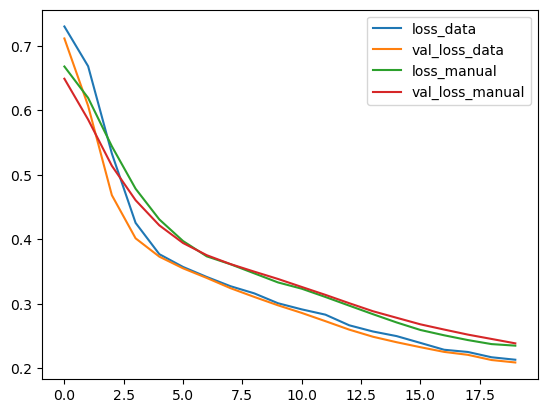

In [70]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data_global['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_global['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_global['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_global['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

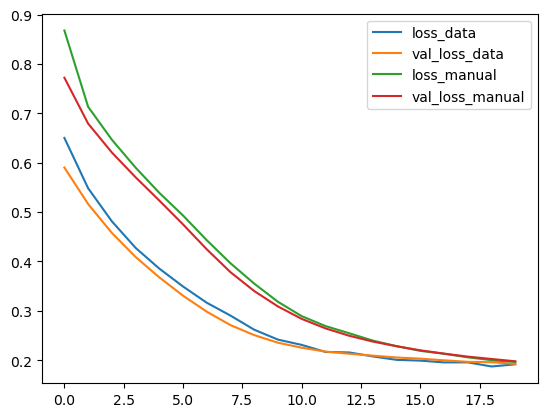

In [71]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data_global_bn['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_global_bn['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_global_bn['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_global_bn['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()